# 5. Example: 4DVar Backprop DA using Reservoir Computing ML Model on QGS Model - Full Run

Using Reservoir Computing model macro-parameters from QGS/Jason Platt's paper: Platt, J. A., Wong, A., Clark, R., Penny, S. G. & Abarbanel, H. D. I. Robust forecasting using predictive generalized synchronization in reservoir computing. Chaos: An Interdisciplinary Journal of Nonlinear Science 31, 123118 (2021).


In [1]:
import dabench as dab
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from qgs.params.params import QgParams
from timeit import default_timer as timer
import pandas as pd
import os

In [2]:
random_seed=55
np_rng = np.random.default_rng(seed=random_seed)

## A. Create Nature Run

In [3]:
# Time parameters
dt = 0.5
# transient time to attractor
transient_time = 1.e5
# integration time on the attractor
integration_time = 1.e4

# Model parameters instantiation with some non-default specs
model_params = QgParams({'phi0_npi': np.deg2rad(50.)/np.pi, 'hd': 0.1})
# Mode truncation at the wavenumber 2 in both x and y spatial coordinate
model_params.set_atmospheric_channel_fourier_modes(2, 2)

# Changing (increasing) the orography depth and the meridional temperature gradient
model_params.ground_params.set_orography(0.2, 1)
model_params.atemperature_params.set_thetas(0.2, 0)

In [4]:
train_size = 100000
valid_size = 10000
transient_size = 1000
test_size = 10000

In [5]:
nature_run = dab.data.QGS(model_params=model_params, store_as_jax=False, delta_t=dt,
                          random_seed=random_seed)
nature_run.generate(n_steps=200*1000, stride=1000, x0=np_rng.random(model_params.ndim)*0.001, mxstep=5000)
x0 = nature_run.values[-1]

In [6]:
nature_run.generate(x0=x0, n_steps=(train_size +  valid_size + transient_size + test_size), mxstep=5000)

In [7]:
# NOTE: This raises a Parameter dimensional conversion warning that can be safely ignored
nr_train, nr_valid, nr_transient_and_test = nature_run.split_train_valid_test(
    train_size, valid_size, transient_size + test_size)
nr_transient, nr_test, _ = nr_transient_and_test.split_train_valid_test(transient_size, test_size, 0)

/home/ksolvik/miniconda3/envs/dab-test-packaging/lib/python3.11/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
  warnings.warn("Parameter configured to perform dimensional conversion " +


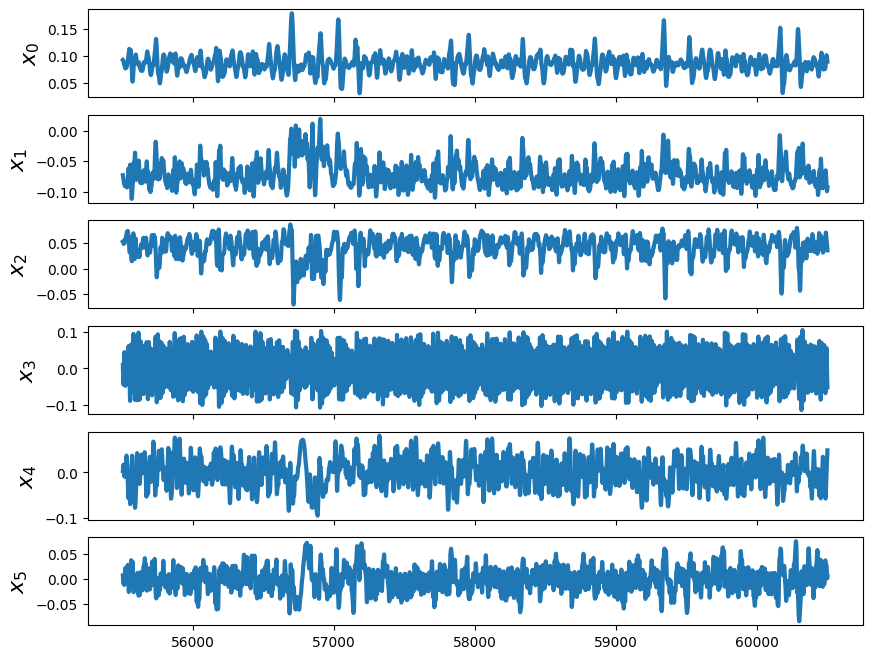

In [8]:
# Let's visualize the results
fig, axes = plt.subplots(6, 1, sharex = True, figsize = (10, 8))
for j, ax in enumerate(axes):
    ax.plot(nr_test.times, nr_test.values[:,j], lw = 3, label = 'Nature Run')
    ax.set_ylabel(r'$x_{:d}$'.format(j), fontsize = 16)
#     ax.set_xlim(54000, 55000)

## B. Generate Observations

In [9]:
# First we need to calculate the per-variable SD for QGS model
obs_sd_scale = 0.1
per_variable_sd = np.std(nr_train.values, axis=0)
obs_sd = 0.1*per_variable_sd

In [10]:

# Now we can define the observer:
obs_qgs_valid = dab.observer.Observer(
    nr_valid, # Data generator object
    time_indices = np.arange(0, nr_valid.time_dim, 3), # Observation every 5th timestep
    random_location_count = 10,
    error_bias = 0.0, 
    error_sd = obs_sd,  
    random_seed=93,
    stationary_observers=True,
    store_as_jax=False
)

obs_qgs_test = dab.observer.Observer(
    nr_test, # Data generator object
    time_indices = np.arange(0, nr_test.time_dim, 3), # Observation every 3rd timestep
    random_location_count = 10,
    error_bias = 0.0, 
    error_sd = obs_sd, 
    random_seed=94,
    stationary_observers=True,
    store_as_jax=False
)


# Making observations
obs_vec_valid = obs_qgs_valid.observe()
obs_vec_test = obs_qgs_test.observe()

## C. Define and train model

In [11]:
# Define model
forecast_model = dab.model.RCModel(
    system_dim=20, 
    reservoir_dim=2000, 
    input_dim=20, 
    sparse_adj_matrix=False, 
    sparsity=0.99,
    readout_method='linear',
    sigma=0.98765777241154,
    sigma_bias = 0.675882947305197,
    spectral_radius =  0.376752115791648, # SR 
    leak_rate=0.5343730100231164, # alpha
    log_beta=-20.219432227197363)

In [12]:
# Checks for presaved weights. If not present, trains RC model and saves weights
weights_path = './out/qgs/rc_weights.pkl'
if os.path.isfile(weights_path):
    # Shortcut: Load previously trained weights
    forecast_model.weights_init()
    forecast_model.load_weights(weights_path)
else:
    # Train: Takes ~5 minutes
    forecast_model.weights_init()
    forecast_model.train(nr_train)
    forecast_model.save_weights(weights_path)

In [13]:
# What happens when we run our model without data assimilation?
valid_start = forecast_model.generate(nr_train.values[-1000:])[-1]

valid_run_hidden = [valid_start]
obs_index = 0
for i in range(valid_size-1):
    valid_run_hidden.append(
        forecast_model.update(valid_run_hidden[-1],
                              forecast_model.readout(valid_run_hidden[-1])
                              )
    )
valid_run_system = forecast_model.readout(valid_run_hidden)



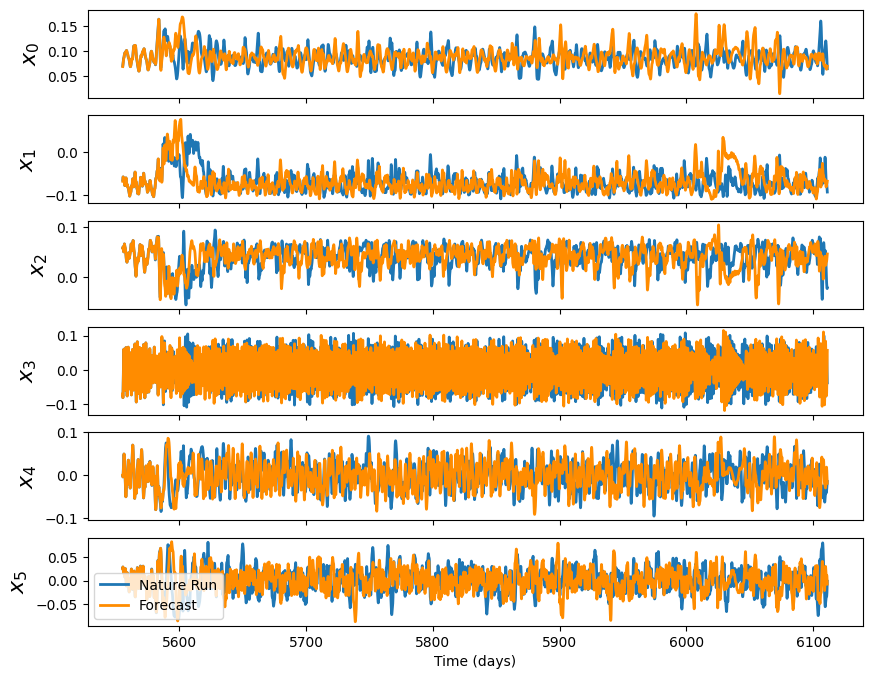

In [14]:
# Let's visualize the results
fig, axes = plt.subplots(6, 1, sharex = True, figsize = (10, 8))
for j, ax in enumerate(axes):
    ax.plot(nr_valid.times*160/(60*24), nr_valid.values[:,j], lw = 2, label = 'Nature Run')
    ax.plot(nr_valid.times*160/(60*24), valid_run_system[:,j], lw = 2, label = 'Forecast', color='darkorange')
    ax.set_ylabel(r'$x_{:d}$'.format(j), fontsize = 16)
ax.legend()
ax.set_xlabel('Time (days)')
plt.show()

In [15]:
# Repeat the same thing on test set for paper figure
test_start = forecast_model.generate(nr_transient.values[-1000:])[-1]

test_run_hidden = [test_start]
obs_index = 0
for i in range(test_size-1):
    test_run_hidden.append(
        forecast_model.update(test_run_hidden[-1],
                              forecast_model.readout(test_run_hidden[-1])
                              )
    )
test_run_system = forecast_model.readout(test_run_hidden)



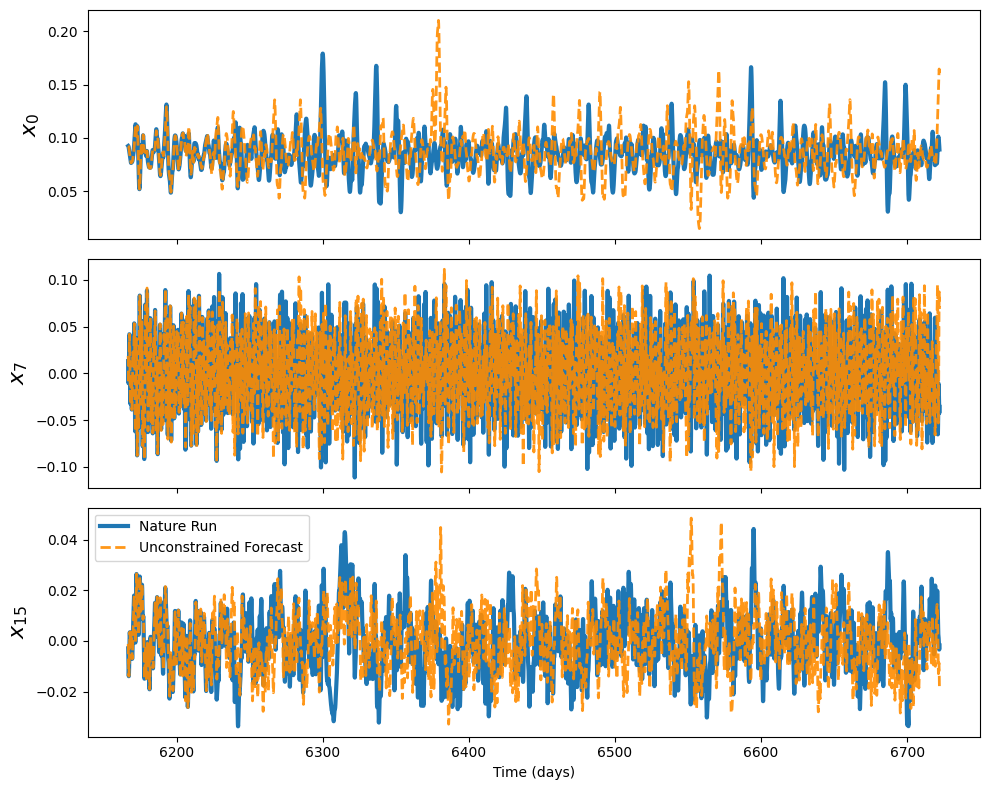

In [16]:
# Plot them all
fig, axes = plt.subplots(3, 1, sharex = True, figsize = (10, 8))
# fig.suptitle('Backprop-4DVar, QGS Nature Run with RC Forecast Model')
vars_to_plot = [0, 7, 15]
for i, ax in enumerate(axes):
    j = vars_to_plot[i]
    ax.plot(nr_test.times*160/(60*24), nr_test.values[:,j], lw = 3, label = 'Nature Run')
    ax.plot(nr_test.times*160/(60*24), test_run_system[:,j], label = 'Unconstrained Forecast', color='darkorange',
           ls='--', lw=2, alpha=0.9)
    ax.set_ylabel(r'$x_{' +str(j) + '}$', fontsize = 16)
    if i == 2:
        ax.legend()
ax.set_xlabel('Time (days)')
nr_test_unconstrained = deepcopy(nr_test)
test_run_unconstrained= deepcopy(test_run_system)

# ax.set_xlim(10090, 12110)
fig.tight_layout()
plt.show()

## D. Set up and run DA Cycler for validation period

In [17]:
# Load lr and lr_decay from raytune
raytune_results = pd.read_csv('./out/qgs/raytune_qgs_v12_hessian.csv')
best_row = raytune_results['rmse'].idxmin()
best_lr = raytune_results.loc[best_row, 'config/lr'] #0.019 #
best_lr_decay = raytune_results.loc[best_row, 'config/lr_decay'] #0.875

In [18]:
# Getting standard deviation of reservoir state values for sigma_bg
train_res_values = forecast_model.generate(nr_train.values)
train_res_sd = np.std(train_res_values, axis=0)

In [19]:
sigma_bg = 0.1*train_res_sd #0.005 #0.05*obs_sd
sigma_obs=np.tile(obs_sd[obs_vec_valid.location_indices[0]], 1)*1.25


R_valid = (sigma_obs**2)*np.identity(obs_vec_valid.location_indices[0].shape[0])
B = (sigma_bg**2)*np.identity(forecast_model.reservoir_dim)
S = np.zeros((10, 20))
S[np.arange(S.shape[0]), np.tile(obs_vec_valid.location_indices[0], 1)] = 1
H_valid = S @ forecast_model.Wout.T

In [20]:
r0_original = forecast_model.update(forecast_model.generate(
        nr_train.values[-1000:]
        + np_rng.normal(size = (1000, nr_train.system_dim), scale=obs_sd))[-1], nr_train.values[-1])

In [21]:
def setup_run_v4d_bp(nr, r0, obs_vec, num_iters, learning_rate, lr_decay,
                     H, B, R):
    
    dc = dab.dacycler.Var4DBackprop(
        system_dim=forecast_model.reservoir_dim,
        delta_t=nr.delta_t,
        H=H,
        B=B,
        R=R,
        learning_rate=learning_rate,
        lr_decay=lr_decay,
        num_iters=num_iters,
        model_obj=forecast_model,
        obs_window_indices=[0,2,5,8],
        steps_per_window=10, # 10 instead of 9 because inclusive of start and end
        loss_growth_limit=1000
    )
    cur_tstep = 0

    r0_sv = dab.vector.StateVector(
        values=r0,
        store_as_jax=True)

    out_statevec = dc.cycle(
        input_state = r0_sv,
        start_time = nr.times[cur_tstep],
        obs_vector = obs_vec,
        analysis_window=4.5,
        timesteps=int(nr.time_dim/9)-2,
        obs_error_sd=sigma_obs,
        analysis_time_in_window=2.25)
    
    analyses_stacked = forecast_model.readout(out_statevec.values)
    
    return analyses_stacked

Run the cycler

In [22]:
num_iters_list = [5, 4, 3, 2, 1] 
output_list = []
times_list = []

for ne in num_iters_list:
    start = timer()
    cur_output = setup_run_v4d_bp(
        nr=nr_valid, 
        r0 = r0_original,
        obs_vec = obs_vec_valid,
        num_iters = ne,
        learning_rate = best_lr,
        lr_decay = best_lr_decay,
        H=H_valid,
        B=B,
        R=R_valid)
    times_list.append(timer()-start)
    output_list.append(cur_output)
    print('{} Done, Time = {}'.format(ne, times_list[-1]))

    
results_dict = {
    'num_iters': num_iters_list,
    'time': times_list
}

results_dict['rmse'] = [np.sqrt(np.mean(np.square(nr_valid.values[:-19] - out))) for out in output_list]

time_rmse_df = pd.DataFrame(results_dict)

time_rmse_df.to_csv('./out/qgs/qgs_bp_v13_raytune_results_hessian.csv')

5 Done, Time = 232.181550401001
4 Done, Time = 192.08632901698002
3 Done, Time = 150.88367893200484
2 Done, Time = 117.26742742798524
1 Done, Time = 85.81539342799806


# Figure: num iters vs. time vs rmse

In [23]:
time_rmse_df = pd.read_csv('./out/qgs/qgs_bp_v13_raytune_results_hessian.csv')

In [24]:
time_rmse_df['time_per_cycle'] = time_rmse_df['time']/(int(valid_size/9)-2)

In [25]:
time_rmse_df

,Unnamed: 0,num_iters,time,rmse,time_per_cycle
0,0,5,232.181550,0.004352,0.209361
1,1,4,192.086329,0.004359,0.173207
2,2,3,150.883679,0.004377,0.136054
3,3,2,117.267427,0.010518,0.105742
4,4,1,85.815393,0.920824,0.077381


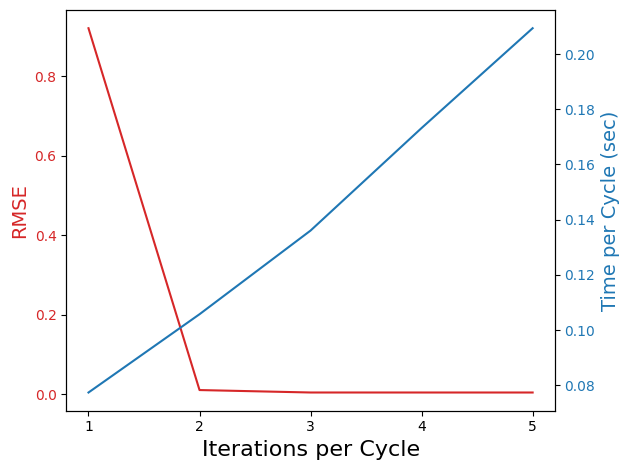

In [26]:
# Visualize time vs RMSE

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Iterations per Cycle', size=16)
ax1.set_ylabel('RMSE', color=color, size=14)
ax1.plot(time_rmse_df['num_iters'], time_rmse_df['rmse'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(np.arange(1, 6))

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('Time per Cycle (sec)', color=color, size=14)
ax2.plot(time_rmse_df['num_iters'], time_rmse_df['time_per_cycle'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [27]:
analyses_stacked = output_list[2]

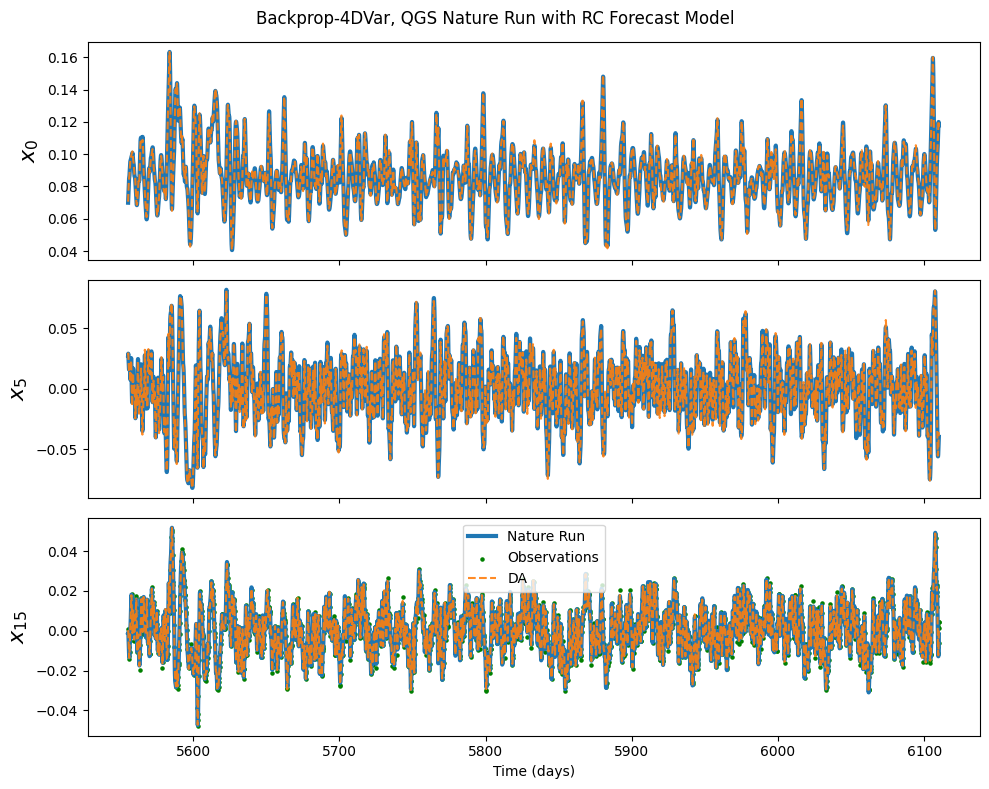

In [28]:
# Plot them all
fig, axes = plt.subplots(3, 1, sharex = True, figsize = (10, 8))
fig.suptitle('Backprop-4DVar, QGS Nature Run with RC Forecast Model')
vars_to_plot = [0, 5, 15]
for i, ax in enumerate(axes):
    j = vars_to_plot[i]
    ax.plot(nr_valid.times[:-19]*160/(60*24), nr_valid.values[:-19, j], label='Nature Run', lw=3)
    if j in obs_vec_valid.location_indices[0]:
        ax.scatter(obs_vec_valid.times[:-4]*160/(60*24),
                   obs_vec_valid.values[:-4, np.where(j == obs_vec_valid.location_indices[0])[0]],
                   label='Observations',color='green', s=5)
    ax.plot(nr_valid.times[:analyses_stacked.shape[0]]*160/(60*24), analyses_stacked[:, j],
            label='DA', ls='--', lw=1.5, alpha=0.9)
    ax.set_ylabel(r'$x_{' +str(j) + '}$', fontsize = 16)
    if i == 2:
        ax.legend()
ax.set_xlabel('Time (days)')

# ax.set_xlim(10090, 12110)
fig.tight_layout()
plt.show()

In [29]:
np.sqrt(np.mean(np.square(nr_valid.values[:-19] - analyses_stacked)))

np.float64(0.0043771476911029705)

# E. Run for test period

In [30]:
r0_original_test = forecast_model.update(forecast_model.generate(
        nr_transient.values
        +  np_rng.normal(size = (nr_transient.time_dim, nr_transient.system_dim), scale=obs_sd))[-1], nr_transient.values[-1])

In [31]:
sigma_obs=np.tile(obs_sd[obs_vec_test.location_indices[0]], 1)*1.25 # Used 0.005 normally, 0.01 increased error
sigma_bg = 0.1*train_res_sd #0.005 #0.05*obs_sd

R_test = (sigma_obs**2)*np.identity(10)
B = (sigma_bg**2)*np.identity(forecast_model.reservoir_dim)
S = np.zeros((10, 20))
S[np.arange(S.shape[0]), np.tile(obs_vec_test.location_indices[0], 1)] = 1
H_test = S @ forecast_model.Wout.T

In [32]:
num_iters = 3

start = timer()

cur_output = setup_run_v4d_bp(
    nr=nr_test, 
    r0 = r0_original_test,
    obs_vec = obs_vec_test,
    num_iters = num_iters,
    learning_rate = best_lr,
    lr_decay = best_lr_decay,
    H=H_test,
    B=B,
    R=R_test)

print(timer()-start)



162.23041025799466


In [33]:
np.sqrt(np.mean(np.square(nr_test.values[:-19] - cur_output)))

np.float64(0.00442213424434041)

In [34]:
analyses_stacked = cur_output

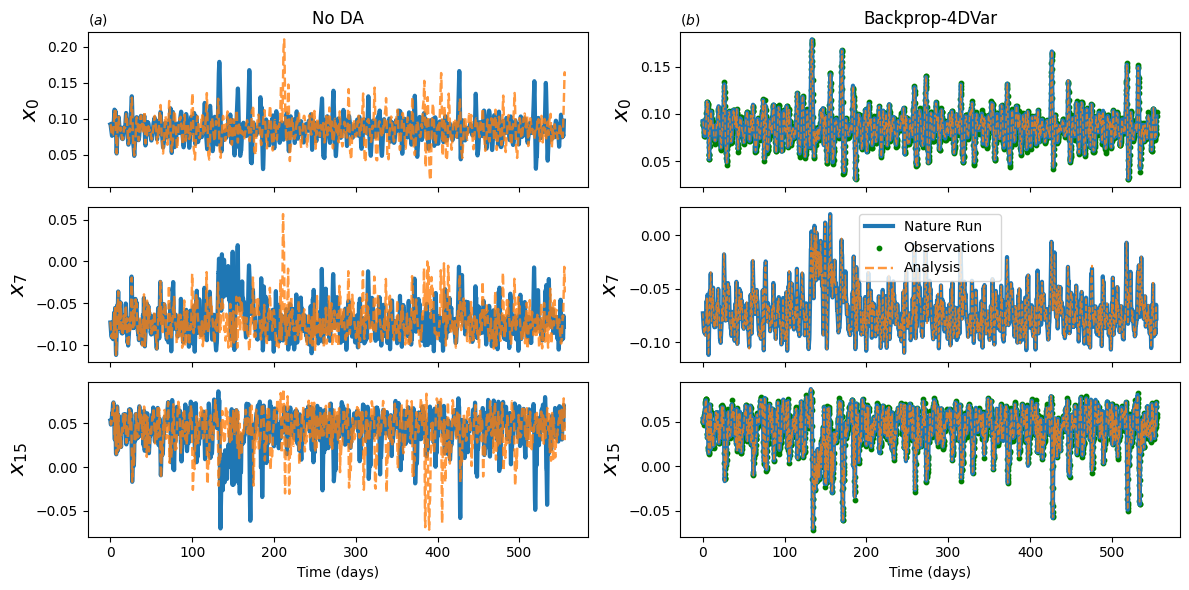

In [35]:
# Plot baseline vs backprop-4dvar
fig, axes = plt.subplots(3, 2, sharex = True, figsize = (12, 6))
vars_to_plot = [0, 7, 15]
for j, ax in enumerate(axes):
    if j ==0:
        ax[0].set_title('No DA')
        ax[1].set_title('Backprop-4DVar')

    for i in range(len(ax)):
        obj1 = ax[i].plot((nr_test.times[:-19] - nr_test.times[0])*160/(60*24), nr_test.values[:-19, j], label='Nature Run', lw=3)
        if j in obs_vec_test.location_indices[0] and i == 1:
            obj2 = ax[i].scatter((obs_vec_test.times[:-4] - obs_vec_test.times[0])*160/(60*24),
                       obs_vec_test.values[:-4, np.where(j == obs_vec_test.location_indices[0])[0]],
                       label='Observations',color='green', s=10)
        ax[i]
        ax[i].set_ylabel(r'$x_{' +str(vars_to_plot[j]) + '}$', fontsize = 16)
    
    obj4 = ax[1].plot((nr_test.times[:analyses_stacked.shape[0]] - nr_test.times[0])*160/(60*24), analyses_stacked[:, j],
                label='Analysis', ls='--', lw=1.0, alpha=0.8)
    obj3 = ax[0].plot((nr_test.times - nr_test.times[0])*160/(60*24), test_run_unconstrained[:, j],
            label='Analysis', ls='--', lw=1.75, alpha=0.8)
    if j ==1:
        ax[1].legend(handles=[obj1[0], obj2, obj3[0]])

ax[0].set_xlabel('Time (days)')
ax[1].set_xlabel('Time (days)')

axes[0, 0].set_title('$(a)$', fontfamily='serif', loc='left', fontsize='medium')
axes[0, 1].set_title('$(b)$', fontfamily='serif', loc='left', fontsize='medium')


fig.tight_layout()


plt.show()